This notebook implements the deep hedging framework for a basket option, which is a derivative depending on the average of a number of stocks. It extends the base model that can be found in the other file in the repository and again is based on the implementation by Josef Teichmann (https://people.math.ethz.ch/~jteichma/index.php?content=teach_mlf2019). 

In [1]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\laura\anaconda3\envs\Dissertation\lib\site-

Now, instead of one stock price, we look at two stocks that will form the basket. 

In [2]:
N = 20
spot = [1, 1.5]
vol = [.1,.2,]
riskfreerate = 0
T = 1
strike = 1

In [3]:
spotbasket = spot
print(spotbasket[0], spotbasket[1])

1 1.5


We will do a different normalization because we need to this for every duo of increments such that we have one averaged increment out of the two stock prices for each time interval.

We store each increment in a matrix such that that can be substituted into the training data.

In [4]:
np.random.seed(0) ;
paths = 10**5

#we somehow also need to store the increments
increment_matrix = np.zeros((N,paths))
logS1= np.zeros((N,paths))
logS1[0,]=np.log(spotbasket[0])*np.ones((1,paths))
logS2= np.zeros((N,paths))
logS2[0,]=np.log(spotbasket[1])*np.ones((1,paths))

for i in range(paths):
    for j in range(N-1):
        increment1 = np.random.normal(-(vol[0])**2*T/(2*N),vol[0]*np.sqrt(T)/np.sqrt(N))
        #increment_matrix1[j+1,i] = increment1
        logS1[j+1,i] =logS1[j,i]+increment1
        increment2 = np.random.normal(-(vol[1])**2*T/(2*N),vol[1]*np.sqrt(T)/np.sqrt(N))
        logS2[j+1,i] =logS2[j,i]+increment2
        increment_matrix[j+1,i] = 0.5*increment1 + 0.5*increment2

We calculate the option value of the basket option through Monte Carlo.

In [5]:
S1=np.exp(logS1)
GBM1 = S1[N-1,:]
S2=np.exp(logS2)
GBM2 = S2[N-1,:]
#print(GBM1, GBM2)

#GBM = .5*GBM1/spotbasket[0] + .5*GBM2/spotbasket[1]
GBM = 0.5*GBM1 + 0.5*GBM2
#print(GBM)
zerovec = np.zeros(paths)
strikevec = np.ones(paths)

optionvalue = np.exp(-riskfreerate*T)*np.maximum(GBM-strikevec,zerovec).mean()
print(optionvalue)

0.25195497771480424


We could now input the increment matrix of the average increments of the basket option and input the option value that we calculated through Monte Carlo in the implementation in the base model algorithm. Instead, we could also calculate the implied volatility of the basket option and use the same neural network structure to hedge a call option with as underlying the basket option.

In [6]:
import scipy as sc
from scipy import stats

def BSCall(strikeloc = 1.0,
           maturityloc = 1.0,
           spotloc = 1.0,
           volloc = .1,
           riskfreerateloc = 0.0
          ):
    
    d1 = (np.log(spotloc/strikeloc) + (riskfreerateloc + volloc*volloc*0.5)*maturityloc)/(volloc*np.sqrt(maturityloc))
    d2 = d1 - volloc*np.sqrt(maturityloc)
    
    return spotloc*stats.norm.cdf(d1, 0.0, 1.0) - strikeloc * np.exp(-riskfreerateloc*maturityloc)*stats.norm.cdf(d2, 0.0, 1.0)

#singleoptionValueBSCall = BSCall(100, 5, 100, .1, 0.05)
singleoptionValueBSCall = BSCall(1, 5, 1, 0.1, 0.05)
singleoptionValueBSCall

0.23421057251191357

Now we calculate the implied volatility of the basket option.

In [15]:
def implyvol(price,
            maturity,
            strike,
             spot,
            rate):
    
    up = 1
    down = 0.001
    
    for i in range(0,1000):
        mid = (down+up)/2
        priceup = BSCall(strike,maturity,spot,up,rate)
        pricemid = BSCall(strike,maturity,spot,mid,rate)
        pricedown = BSCall(strike,maturity,spot,down,rate)
        
        if (pricedown < price) & (price < pricemid):
            up = mid
        elif ( pricemid <= price) & (price < priceup):
            down = mid
        #else:
        #    raise Exception("Couldnt solve for vol: ", mid, ", ", i, ", ",pricedown,", ",pricemid, ", ", priceup)
        
    impliedvol = mid
    return impliedvol, i, pricemid

In [19]:
result = implyvol(optionvalue,T, strikevec.mean(), 1.25, riskfreerate)
print(result)

(0.12373255414633147, 999, 0.2519549777148046)


In [21]:
impliedvol = result[0]
print(impliedvol)

0.12373255414633147


In [24]:
priceBS = BSCall(strikevec.mean(), T, 1.25, impliedvol, riskfreerate)
print(priceBS)

0.2519549777148046


We will now implement the model with a call option on the basket option, using the implied volatility! We have an underlying stock with spot 1.25, strike 1, T = 1, and implied volatility 0.123732. 

In [25]:
#Definition of neural networks for hedging strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [26]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
#change this to payoff of basket
payoff= Lambda(lambda x : 0.5*(K.abs(x - strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
print(len(outputs))
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

22
20


In [27]:
model_hedge_strat.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1)            0           lambda_1[0][0]                   
                                                                 input_5[0][0]              

In [28]:
Ktrain = paths
initialprice = 1.25

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.ones((Ktrain,m))]+
          [np.random.normal(-(impliedvol)**2*T/(2*N),impliedvol*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
print(len(xtrain))

ytrain=np.zeros((Ktrain,1+N))

24


In [29]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z

In [30]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

In [31]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)



Epoch 1/1
100000/100000 [==============================] - 18s 179us/step - loss: 0.0773
Epoch 1/1
100000/100000 [==============================] - 16s 163us/step - loss: 1.1719e-04
Epoch 1/1
100000/100000 [==============================] - 17s 168us/step - loss: 9.4153e-05
Epoch 1/1
100000/100000 [==============================] - 19s 187us/step - loss: 7.7567e-05
Epoch 1/1
100000/100000 [==============================] - 19s 188us/step - loss: 5.7674e-05


1100000


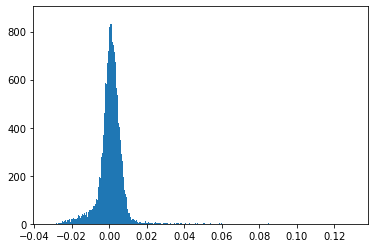

mean of loss is 0.00072411797
standard deviation of loss is 0.0068861917
mean of BS-price is 0.2512288
standard deviation of BS-price is 0.0


In [32]:
Ktest1 = 50000
xtest1 = ([initialprice*np.ones((Ktest1,m))] +
          [np.zeros((Ktest1,m))]+
          [np.ones((Ktest1,m))] +
          [priceBS*np.ones((Ktest1,m))]+
          [np.random.normal(-(impliedvol)**2*T/(2*N),impliedvol*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
y_test1 = model_hedge_strat.predict(xtest1)
print(y_test1.size)
plt.hist(y_test1[:,0], bins=1000)
plt.show()
print('mean of loss is', np.mean(y_test1[:,0]))
print('standard deviation of loss is', np.std(y_test1[:,0]))
print('mean of BS-price is', np.mean(y_test1[:, N+1]))
print('standard deviation of BS-price is', np.std(y_test1[:, N+1]))

Now create a test set of size ten and plot the hedge.

In [33]:
Ktest2= 10
xtest2 = ([initialprice*np.ones((Ktest2,m))] +
          [np.zeros((Ktest2,m))]+
          [np.linspace(0.5,1.5,Ktest2)] +#change this if you go to higher dimensions
          [priceBS*np.ones((Ktest2,m))]+
          [np.random.normal(-(impliedvol)**2*T/(2*N),impliedvol*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
y_whole2 = model_hedge_strat.predict(xtest2)
y2 = y_whole2[:,10]
print(y2)
print(y2[1])

[-0.00333093  0.19045109  0.39470342  0.58475083  0.74108124  0.8573772
  0.9381623   0.9920852   1.0273226   1.0500361 ]
0.19045109


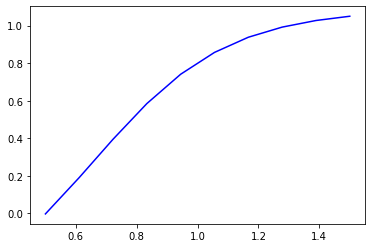

In [34]:
l = 9
s=np.linspace(0.5,1.5,Ktest2)
plt.plot(s,y2,'b')
plt.show()